#### Enlace Repositorio GitHub:

https://github.com/juan5733/DS_Proyecto_04_SR.git

## Background

A lo largo del proyecto número 3 he implementado un filtro colaborativo para determinar que juegos recomendar a un usuario en particular, en base a los juegos jugados por otros usuarios. Para el caso de este proyecto, buscaré desarrollar un filtro basado en contenido para recomendar juegos a un usuario en particular, pero en base a la similitud entre juegos y no entre usuarios.

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

A continuación utilizaré el archivo preprocesado de la entrega anterior para comenzar con la implementación del filtro colaborativo

In [290]:
#carga del dataset pre-armado que fui generando durante EDA del proyecto 03
games = pd.read_csv('games.csv')

In [292]:
games.head()

,publisher,genres,app_name,title,release_date,tags,specs,price,early_access,id,developer,sentiment
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],4.99,False,761140.0,Kotoshiro,NaN
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",0.00,False,643980.0,Secret Level SRL,Mostly Positive
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",0.00,False,670290.0,Poolians.com,Mostly Positive
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,2017-12-07,"['Action', 'Adventure', 'Casual']",['Single-player'],0.99,False,767400.0,彼岸领域,NaN
4,NaN,NaN,Log Challenge,NaN,NaN,"['Action', 'Indie', 'Casual', 'Sports']","['Single-player', 'Full controller support', '...",2.99,False,773570.0,NaN,NaN


### EDA

Como expliqué anteriormente el punto clave de este filtro es la similitud entre juegos (en base a sus características) por ende profundizaré el EDA realizado en el proyecto anterior en este dataset: 

In [293]:
games.shape

(31203, 12)

In [294]:
games.isna().sum()

publisher       7903
genres          3234
app_name           2
title           2013
release_date    2029
tags             160
specs            555
price              0
early_access       0
id                 2
developer       3250
sentiment       7017
dtype: int64

La columna "app_name" y "title" poseen la misma información, por lo que observando la cantidad de valores nulos de "title" procedo a eliminarla y continuar trabajando con "app_name".

In [295]:
games = games.drop(columns=['title'], axis=1)
games = games[games.app_name.isna() == False] #Además elimino los juegos sin nombre
games = games[games.id.isna() == False] #Además elimino los juegos sin id

In [296]:
print("Cantidad de valores distintos de publisher:", len(games['publisher'].unique()))
print("Cantidad de valores distintos de developer:", len(games['developer'].unique()))

Cantidad de valores distintos de publisher: 8163
Cantidad de valores distintos de developer: 10872


En base a la alta cantidad de valores distintos de las columnas "publisher" y "developer" procederé a eliminarlas ya que no aportarán ningún valor a la elaboración del filtro. Lo mismo sucede con la columna "release_date".

In [297]:
games = games.drop(columns=['publisher','developer', 'release_date'], axis=1)
games.head()

,genres,app_name,tags,specs,price,early_access,id,sentiment
0,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],4.99,False,761140.0,NaN
1,"['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",0.00,False,643980.0,Mostly Positive
2,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",0.00,False,670290.0,Mostly Positive
3,"['Action', 'Adventure', 'Casual']",弹炸人2222,"['Action', 'Adventure', 'Casual']",['Single-player'],0.99,False,767400.0,NaN
4,NaN,Log Challenge,"['Action', 'Indie', 'Casual', 'Sports']","['Single-player', 'Full controller support', '...",2.99,False,773570.0,NaN


In [298]:
games.shape

(31200, 8)

#### Encoding y transformación de datos

In [299]:
games['early_access'].unique()

array([False,  True])

La columna "early_access" puedo convertirla a una columna booleana con valores 0 (sin acceso anticipado) y 1 (con acceso anticipado) para un tratamiento más eficiente

In [300]:
games['early_access']=games['early_access'].replace({False: 0, True: 1})
games['early_access'].unique()

array([0, 1], dtype=int64)

Las columnas "genres", "tags" y "specs" son actualmente "strings", por tanto deben ser convertidas a listas para poder ser utilizadas mediante el filtro basado en contenido

In [301]:
print(games.iloc[0,0]) #Ejemplo de "genres" del primer registro
print(type(games.iloc[0,0]))

['Action', 'Casual', 'Indie', 'Simulation', 'Strategy']
<class 'str'>


In [302]:
from ast import literal_eval
# Convierto el string a una lista
def get_list(registro):
    if type(registro) == str:
            return literal_eval(registro)
    return np.nan

In [303]:
games['genres'] = games['genres'].apply(lambda x: get_list(x))
games['tags'] = games['tags'].apply(lambda x: get_list(x))
games['specs'] = games['specs'].apply(lambda x: get_list(x))

In [304]:
print(games.iloc[0,0]) #Ejemplo de "genres" del primer registro
print(type(games.iloc[0,0]))

['Action', 'Casual', 'Indie', 'Simulation', 'Strategy']
<class 'list'>


In [305]:
games.head()

,genres,app_name,tags,specs,price,early_access,id,sentiment
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,0,761140.0,NaN
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",0.00,0,643980.0,Mostly Positive
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",0.00,0,670290.0,Mostly Positive
3,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],0.99,0,767400.0,NaN
4,NaN,Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,0,773570.0,NaN


In [306]:
#Defino una función para poder generar una lista única con todos los valores de las features de tipo lista

def unique_list(columna):
    unique = []
    for registro in columna:
        if (type(registro) == list):
            for valor in registro:
                unique.append(valor)
    return unique

In [307]:
#Listas con todos los valores de las features
genres= unique_list(games['genres'])
tags= unique_list(games['tags'])
specs= unique_list(games['specs'])

Cantidad de valores distintos de genres: 22


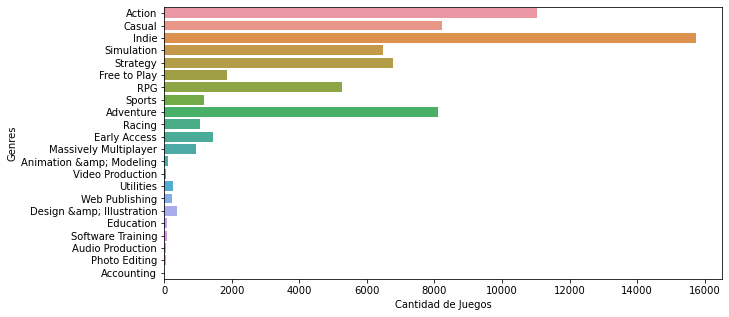

In [308]:
plt.figure(figsize=(10,5))
sns.countplot(y=genres).set(xlabel='Cantidad de Juegos', ylabel='Genres') #Gráfico en Seaborn
print("Cantidad de valores distintos de genres:", len(set(genres)))

Cantidad de valores distintos de Tags: 339


[Text(0.5, 0, 'Cantidad de Juegos'), Text(0, 0.5, 'Tags')]

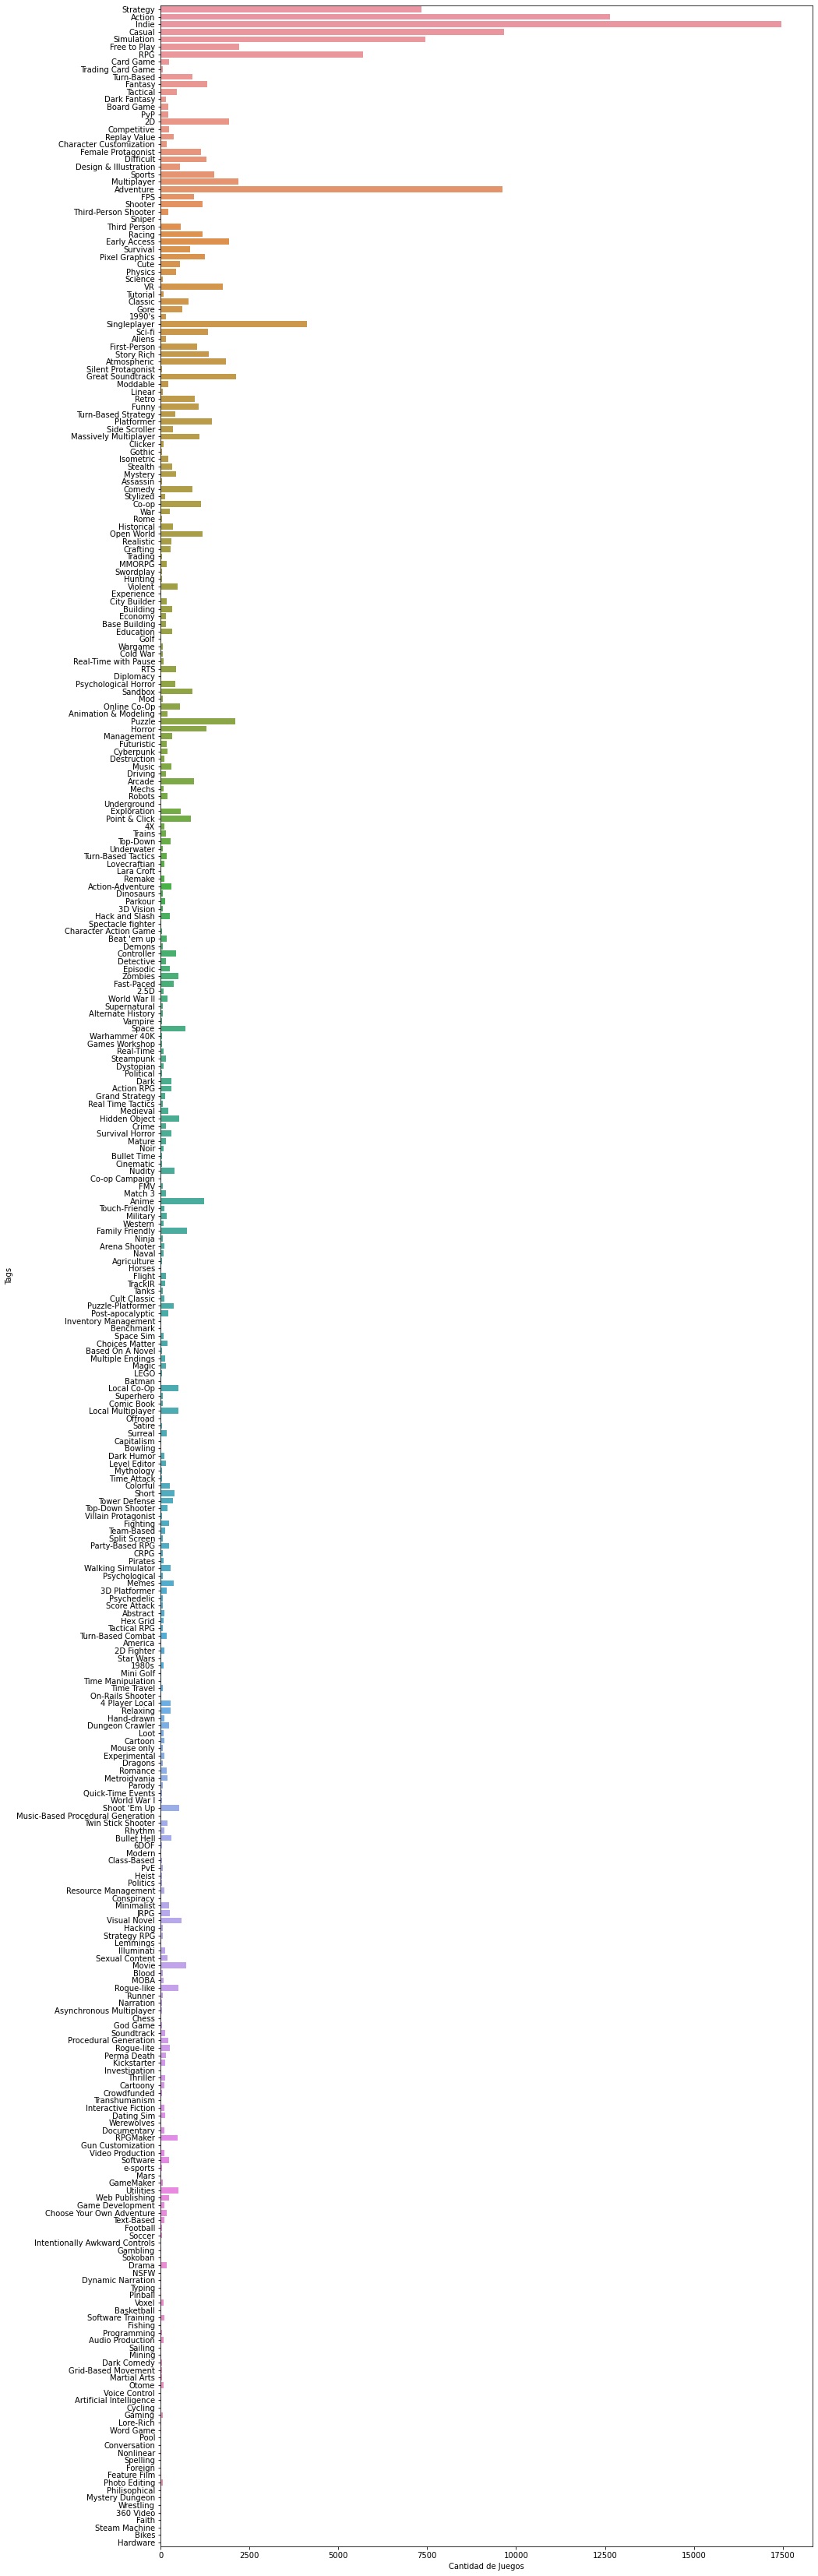

In [309]:
plt.figure(figsize=(15,60))
print("Cantidad de valores distintos de Tags:", len(set(tags)))
sns.countplot(y=tags).set(xlabel='Cantidad de Juegos', ylabel='Tags') #Gráfico en Seaborn

Cantidad de valores distintos de Specs: 40


[Text(0.5, 0, 'Cantidad de Juegos'), Text(0, 0.5, 'Specs')]

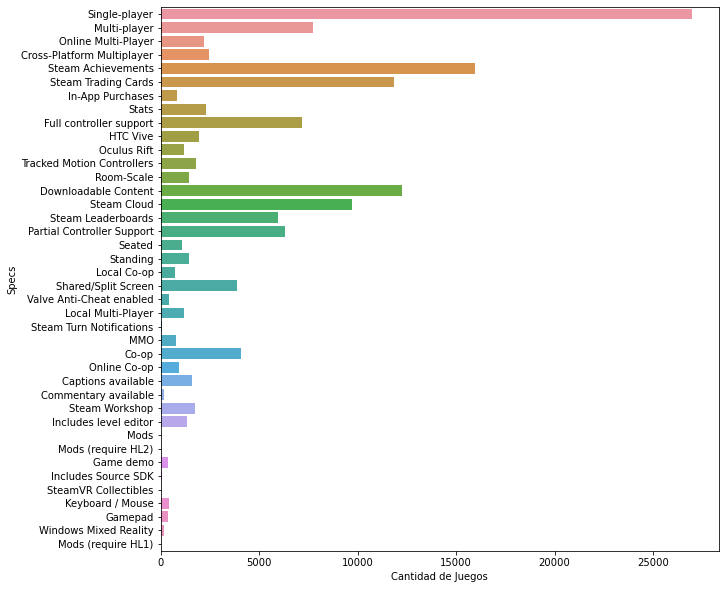

In [310]:
plt.figure(figsize=(10,10))
print("Cantidad de valores distintos de Specs:", len(set(specs)))
sns.countplot(y=specs).set(xlabel='Cantidad de Juegos', ylabel='Specs') #Gráfico en Seaborn

Cantidad de valores distintos de Sentiment: 19


[Text(0.5, 0, 'Cantidad de Juegos'), Text(0, 0.5, 'Sentiment')]

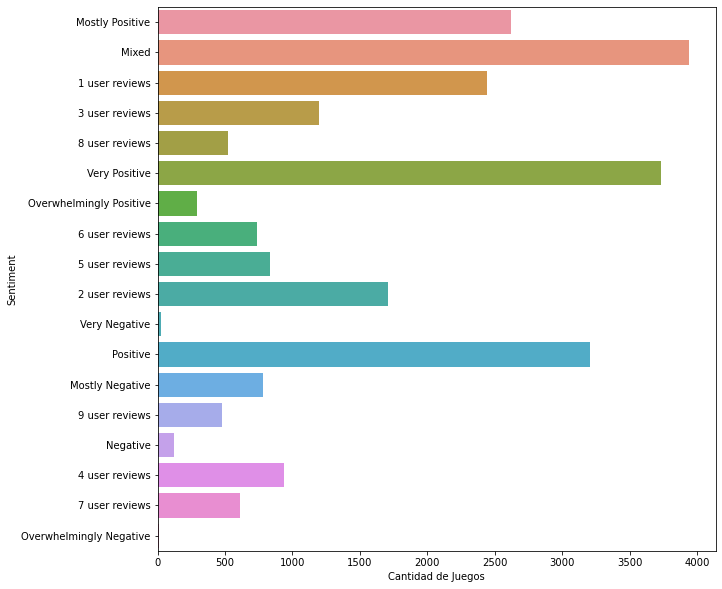

In [311]:
plt.figure(figsize=(10,10))
print("Cantidad de valores distintos de Sentiment:", len(games['sentiment'].unique()))
sns.countplot(data=games,y="sentiment").set(xlabel='Cantidad de Juegos', ylabel='Sentiment') #Gráfico en Seaborn

#### Imputación de valores faltantes

In [312]:
games.corr()

,price,early_access,id
price,1.000000,0.090132,-0.138612
early_access,0.090132,1.000000,0.106766
id,-0.138612,0.106766,1.000000


Debido a la baja correlación entre las variables podemos descartar algún pérdida de valores nulos por MNAR (Missing not At Random)

In [313]:
games.isna().sum()

genres          3233
app_name           0
tags             159
specs            554
price              0
early_access       0
id                 0
sentiment       7016
dtype: int64

In [314]:
print(round((games.isna().sum()* 100/ len(games)),2).sort_values(ascending=False)) #valores faltantes por columna en %

sentiment       22.49
genres          10.36
specs            1.78
tags             0.51
app_name         0.00
price            0.00
early_access     0.00
id               0.00
dtype: float64


Analizaremos a continuación cada una de las columnas que incluyen valores nulos, de forma tal de tratarlas de acuerdo a su origen:

In [315]:
print(round((games.sentiment.value_counts()* 100/ len(games)),2).sort_values(ascending=False)) #valores de sentiment en %

Mixed                      12.62
Very Positive              11.95
Positive                   10.27
Mostly Positive             8.39
1 user reviews              7.82
2 user reviews              5.47
3 user reviews              3.85
4 user reviews              3.00
5 user reviews              2.66
Mostly Negative             2.51
6 user reviews              2.36
7 user reviews              1.95
8 user reviews              1.68
9 user reviews              1.52
Overwhelmingly Positive     0.94
Negative                    0.39
Very Negative               0.09
Overwhelmingly Negative     0.02
Name: sentiment, dtype: float64


Para el caso de la columna "sentiment" podemos observar que sus valores se distribuyen de una forma bastante uniforme, por tanto si tomamos sus 10 valores más ocurrentes representamos un 70% del volumen del dataset. De acuerdo a esto completaré los valores faltantes de forma aleatoria con cualquiera de estos 10 valores:

In [316]:
games['sentiment'] = games['sentiment'].fillna(pd.Series(np.random.choice(['Mixed','Very Positive','Positive','Mostly Positive','1 user reviews','2 user reviews','3 user reviews','4 user reviews','5 user reviews','Mostly Negative']
                                                                                , size=len(games.index)+1)))

In [317]:
games[games.genres.isna()==True]

,genres,app_name,tags,specs,price,early_access,id,sentiment
4,NaN,Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,0,773570.0,Positive
11,NaN,Icarus Six Sixty Six,[Casual],"[Single-player, HTC Vive, Tracked Motion Contr...",0.00,0,724910.0,3 user reviews
18,NaN,After Life VR,"[Early Access, Indie, VR]","[Single-player, HTC Vive, Tracked Motion Contr...",4.99,1,772590.0,Mostly Positive
19,NaN,Kitty Hawk,"[Early Access, Action, Adventure, Indie, Casual]","[Single-player, Steam Leaderboards, HTC Vive, ...",2.99,1,640250.0,4 user reviews
21,NaN,Mortars VR,"[Early Access, Strategy, Action, Indie, Casual...","[Single-player, Multi-player, Online Multi-Pla...",0.99,1,711440.0,8 user reviews
...,...,...,...,...,...,...,...,...
31186,NaN,Robotpencil Presents: Exercise: Brushwork,"[Design & Illustration, Tutorial]",NaN,3.99,0,775640.0,5 user reviews
31187,NaN,Robotpencil Presents: Creative Composition,"[Design & Illustration, Tutorial]",NaN,3.99,0,777930.0,3 user reviews
31188,NaN,The Gamble House,[Movie],[Captions available],4.99,0,775370.0,1 user reviews
31189,NaN,Kalen Chock Presents: 2017 Free Tutorial,"[Design & Illustration, Tutorial]",NaN,0.00,0,777950.0,Mixed


Para el caso de la columna "genres" podemos observar que hay un 10% de valores nulos. Sin embargo luego de realizar un análisis de los datos, podemos observar que la columna "tags" posee muchas veces valores de géneros asociados, aún cuando el registro no tiene valores de géneros. En base a esto desarrollaré una función para detectar (en base a los valores que SI se conocen de géneros para el resto del dataset) cuando un registro tenga en la feature de "tags" valores asociados al género del juego. Una vez detectados estos valores, completaré los valores nulos de la feature de "genres" con los valores de generos que coincidan con sus tags:

In [318]:
generos=set(genres) # Todos los géneros de juegos que se encuentran en el dataset
generos

{'Accounting',
 'Action',
 'Adventure',
 'Animation &amp; Modeling',
 'Audio Production',
 'Casual',
 'Design &amp; Illustration',
 'Early Access',
 'Education',
 'Free to Play',
 'Indie',
 'Massively Multiplayer',
 'Photo Editing',
 'RPG',
 'Racing',
 'Simulation',
 'Software Training',
 'Sports',
 'Strategy',
 'Utilities',
 'Video Production',
 'Web Publishing'}

In [319]:
#Función que devuelve de los tags de un registro cuales pertenecen a su vez a géneros de juegos
def match_genre_tag(tags):
    tags_gen = []
    generos=set(genres)
    if type(tags) == float:
        return np.nan
    for i in tags:
        if (i in generos):
            tags_gen.append(i)
    if len(tags_gen) == 0:
        return np.nan
    return tags_gen

In [320]:
#Recorro todos los registros del dataframe, solo en los que no haya valores trato de completar con valores de géneros incluidos en los tags
i=0
while(i<games.shape[0]):
    if(type(games.genres.iloc[i])!=list):
        games.genres.iloc[i]=match_genre_tag(games.tags.iloc[i])
    i+=1

C:\Users\Juan\miniconda3\envs\datascience\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [321]:
games[games.genres.isna()==True]

,genres,app_name,tags,specs,price,early_access,id,sentiment
25,NaN,Robotpencil Presents: Understanding 3D for Con...,"[Design & Illustration, Tutorial]",NaN,4.990000,0,777910.0,1 user reviews
337,NaN,Nancy Drew® Dossier: Resorting to Danger!,"[Hidden Object, Female Protagonist, Puzzle]",[Single-player],6.990000,0,42200.0,Mostly Positive
356,NaN,Europa Universalis III: Heir to the Throne,NaN,"[Single-player, Multi-player, Downloadable Con...",9.990000,0,25806.0,Positive
429,NaN,Sonic 3D Blast™,"[Platformer, Singleplayer, Great Soundtrack, I...","[Single-player, Partial Controller Support]",4.990000,0,34278.0,6 user reviews
466,NaN,Booster Trooper Demo,NaN,[Game demo],8.867163,0,27930.0,5 user reviews
...,...,...,...,...,...,...,...,...
31055,NaN,Robotpencil Presents: Start with Color,"[Design & Illustration, Tutorial]",NaN,3.990000,0,775660.0,4 user reviews
31186,NaN,Robotpencil Presents: Exercise: Brushwork,"[Design & Illustration, Tutorial]",NaN,3.990000,0,775640.0,5 user reviews
31187,NaN,Robotpencil Presents: Creative Composition,"[Design & Illustration, Tutorial]",NaN,3.990000,0,777930.0,3 user reviews
31188,NaN,The Gamble House,[Movie],[Captions available],4.990000,0,775370.0,1 user reviews


Logré reducir el número de 3233 registros con valores nulos en la columna "genre" a solo 1017 (completé un 7% aproximadamente). Ahora si procederé a eliminar aquellos valores nulos que no han podido ser tratados con el procedimiento anterior:

In [322]:
games = games.dropna(subset=['genres'])

In [323]:
import collections
collections.Counter(specs)

Counter({'Single-player': 26977,
         'Multi-player': 7754,
         'Online Multi-Player': 2214,
         'Cross-Platform Multiplayer': 2452,
         'Steam Achievements': 15947,
         'Steam Trading Cards': 11866,
         'In-App Purchases': 824,
         'Stats': 2288,
         'Full controller support': 7176,
         'HTC Vive': 1950,
         'Oculus Rift': 1183,
         'Tracked Motion Controllers': 1790,
         'Room-Scale': 1426,
         'Downloadable Content': 12262,
         'Steam Cloud': 9712,
         'Steam Leaderboards': 5961,
         'Partial Controller Support': 6339,
         'Seated': 1063,
         'Standing': 1441,
         'Local Co-op': 721,
         'Shared/Split Screen': 3896,
         'Valve Anti-Cheat enabled': 439,
         'Local Multi-Player': 1196,
         'Steam Turn Notifications': 85,
         'MMO': 769,
         'Co-op': 4068,
         'Online Co-op': 918,
         'Captions available': 1603,
         'Commentary available': 194,
    

Para el caso de la columna "specs" podemos observar que casi un 90% de los registros poseen el valor "Single-player" por ende completaré los valores nulos con este valor en particular:

In [324]:
games['specs'] = games['specs'].apply(lambda x: x if isinstance(x, list) else ['Single-player'])

In [325]:
games[games.tags.isna()==True]

,genres,app_name,tags,specs,price,early_access,id,sentiment
277,[Adventure],Nancy Drew®: Ransom of the Seven Ships Demo,NaN,"[Single-player, Game demo]",8.867163,0,31990.0,3 user reviews
296,"[Action, Adventure]",Mini Ninjas Demo,NaN,"[Single-player, Game demo]",8.867163,0,35050.0,Positive
307,[Casual],Freeze Tag Fun Pack #2,NaN,[Single-player],19.990000,0,39392.0,4 user reviews
308,[Casual],Freeze Tag Fun Pack #1,NaN,[Single-player],19.990000,0,39391.0,Very Positive
407,[Casual],Mahjong Roadshow™,NaN,[Single-player],6.990000,0,37360.0,5 user reviews
2046,"[Action, Casual, Indie]",Vitrum Demo,NaN,"[Single-player, Game demo, Includes level editor]",8.867163,0,294350.0,2 user reviews
2074,[Action],Rogue Shooter: The FPS Roguelike Demo,NaN,"[Single-player, Game demo]",8.867163,0,298010.0,Mixed
3025,"[Action, Adventure, Casual, Indie, RPG]",Forward to the Sky Demo,NaN,"[Single-player, Game demo, Partial Controller ...",8.867163,0,348010.0,Mixed
9796,"[Casual, Indie, Simulation, Strategy]",War Chariots: Royal Legion,NaN,[Single-player],5.990000,0,654060.0,4 user reviews
16655,[Accounting],Professor Teaches QuickBooks 2017,NaN,[Single-player],14.990000,0,623590.0,4 user reviews


Para el caso de la columna "tags" observamos que hay solo 23 registros que no poseen valores asociados a esta feature, por tanto podemos eliminarlos ya que no es un valor representativo para el volumen del dataset:

In [326]:
games = games.dropna(subset=['tags'])

In [327]:
games.isna().sum()

genres          0
app_name        0
tags            0
specs           0
price           0
early_access    0
id              0
sentiment       0
dtype: int64

### Modelo de Machine Learning

In [328]:
#Importo las librerías necesarias para la implementación del filtro basado en contenido
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer

El primer paso para poder implementar un filtro basado en contenido se basa en armar la metadata, es decir agrupar los datos para posteriormente tratarlos de forma unívoca y vectorizarlos. Para favorecer el análisis y la recomendación que realizará el filtro, definiré un límite en la cantidad de valores para sus features de tipo lista (genres, tags, specs) para de esta forma facilitar la comparación y la similitud con la que trabajará el filtro. A su vez también quitaré los espacios en los valores de tipo texto ya que dos cadenas de texto que empiecen de la misma forma pueden confundir al sistema de recomendación (de esta forma considera todo como una sola palabra).

In [329]:
#Limite cantidad valores de listas
games['genres'] = games['genres'].apply(lambda x: x[:3] if len(x)>3 else x)
games['tags'] = games['tags'].apply(lambda x: x[:3] if len(x)>3 else x)
games['specs'] = games['specs'].apply(lambda x: x[:3] if len(x)>3 else x)

In [330]:
#Espacios eliminados
games['genres'] = games['genres'].apply(lambda x: [i.replace(' ','') for i in x])
games['tags'] = games['tags'].apply(lambda x: [i.replace(' ','') for i in x])
games['specs'] = games['specs'].apply(lambda x: [i.replace(' ','') for i in x])
games['sentiment'] = games['sentiment'].apply(lambda x: [x.replace(' ','')])

In [331]:
games.head()

,genres,app_name,tags,specs,price,early_access,id,sentiment
0,"[Action, Casual, Indie]",Lost Summoner Kitty,"[Strategy, Action, Indie]",[Single-player],4.99,0,761140.0,[Mixed]
1,"[FreetoPlay, Indie, RPG]",Ironbound,"[FreetoPlay, Strategy, Indie]","[Single-player, Multi-player, OnlineMulti-Player]",0.00,0,643980.0,[MostlyPositive]
2,"[Casual, FreetoPlay, Indie]",Real Pool 3D - Poolians,"[FreetoPlay, Simulation, Sports]","[Single-player, Multi-player, OnlineMulti-Player]",0.00,0,670290.0,[MostlyPositive]
3,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],0.99,0,767400.0,[Mixed]
4,"[Action, Indie, Casual]",Log Challenge,"[Action, Indie, Casual]","[Single-player, Fullcontrollersupport, HTCVive]",2.99,0,773570.0,[Positive]


Todos los datos limpiados y unificados anteriormente deben agruparse en un único feature para que de esta forma el filtro los trabaje y busque similitudes como si fueran un único valor: 

In [332]:
games['metadata'] = games.apply(lambda x: ''.join(x['genres']) + ''+''.join(x['tags']) + '' + ''.join(x['specs']) + '' + ''.join(x['sentiment']), axis=1)
games.head()

,genres,app_name,tags,specs,price,early_access,id,sentiment,metadata
0,"[Action, Casual, Indie]",Lost Summoner Kitty,"[Strategy, Action, Indie]",[Single-player],4.99,0,761140.0,[Mixed],ActionCasualIndieStrategyActionIndieSingle-pla...
1,"[FreetoPlay, Indie, RPG]",Ironbound,"[FreetoPlay, Strategy, Indie]","[Single-player, Multi-player, OnlineMulti-Player]",0.00,0,643980.0,[MostlyPositive],FreetoPlayIndieRPGFreetoPlayStrategyIndieSingl...
2,"[Casual, FreetoPlay, Indie]",Real Pool 3D - Poolians,"[FreetoPlay, Simulation, Sports]","[Single-player, Multi-player, OnlineMulti-Player]",0.00,0,670290.0,[MostlyPositive],CasualFreetoPlayIndieFreetoPlaySimulationSport...
3,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],0.99,0,767400.0,[Mixed],ActionAdventureCasualActionAdventureCasualSing...
4,"[Action, Indie, Casual]",Log Challenge,"[Action, Indie, Casual]","[Single-player, Fullcontrollersupport, HTCVive]",2.99,0,773570.0,[Positive],ActionIndieCasualActionIndieCasualSingle-playe...


Posteriormente al armado de la metadata se debe vectorizar esta columna para de esta forma armar una matriz "gigante" cuyos valores estarán compuestos por cada uno de los índices de cada juego junto con su metadata. Usaré la métrica "similitud de coseno" para evaluar la similitud entre dos juegos. 

In [334]:
games = games.reset_index(drop=True) # Reseteo los índices del dataset previamente a vectorizar
count_vec = CountVectorizer()
count_vec_matrix = count_vec.fit_transform(games['metadata']) # vectorización
cosine_sim_matrix = cosine_similarity(count_vec_matrix, count_vec_matrix) # matriz de similitud entre juegos

In [335]:
mapping = pd.Series(games.index,index = games['app_name']) #Se debe setear como índice a los títulos de los juegos para observar los resultados entre las similitudes

Creo una función para comparar un juego determinado utilizando la matriz de similitud creada anteriormente y obtener los 15 juegos más similares:

In [336]:
def recommend_games(game):
    game_index = mapping[game]
    #Busca en la matriz de similitud, cuan parecido es ese juego con otros (usando distancia vectorial)
    similarity_score = list(enumerate(cosine_sim_matrix[game_index]))
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    #En la lista me quedo con los 15 juegos más similares
    similarity_score = similarity_score[1:16] #El valor 16 corresponde a que el primer valor de la lista es el mismo juego (distancia 0) por tanto me quedo con los 15 juegos siguientes
    game_indices = [i[0] for i in similarity_score]
    return (games['app_name'].iloc[game_indices])

Elijo un juego para probar el sistema de recomendación:

In [361]:
games[games['app_name']=='Disney Universe']

,genres,app_name,tags,specs,price,early_access,id,sentiment,metadata
26441,"[Action, Adventure]",Disney Universe,"[FamilyFriendly, Adventure, Action]","[Single-player, Shared/SplitScreen, Fullcontro...",19.99,0,316260.0,[VeryPositive],ActionAdventureFamilyFriendlyAdventureActionSi...


Ejecuto el sistema para que me recomiende juegos similares:

In [360]:
recomendados = recommend_games("Disney Universe")
games[games.app_name.isin(recomendados)]

,genres,app_name,tags,specs,price,early_access,id,sentiment,metadata
172,"[Action, Adventure]",LEGO Batman,"[LEGO, Action, Adventure]","[Single-player, Shared/SplitScreen, Fullcontro...",19.99,0,21000.0,[VeryPositive],ActionAdventureLEGOActionAdventureSingle-playe...
338,[Adventure],LEGO® Star Wars™ - The Complete Saga,"[LEGO, StarWars, Adventure]","[Single-player, Shared/SplitScreen, Fullcontro...",19.99,0,32440.0,[VeryPositive],AdventureLEGOStarWarsAdventureSingle-playerSha...
848,"[Action, Adventure]",Rayman® Origins,"[Platformer, LocalCo-Op, 2D]","[Single-player, Shared/SplitScreen, Fullcontro...",19.99,0,207490.0,[VeryPositive],ActionAdventurePlatformerLocalCo-Op2DSingle-pl...
944,"[Action, Adventure]",LEGO® Batman 2 DC Super Heroes™,"[LEGO, Action, Batman]","[Single-player, Shared/SplitScreen, Fullcontro...",19.99,0,213330.0,[VeryPositive],ActionAdventureLEGOActionBatmanSingle-playerSh...
1808,"[Action, Casual, Indie]",Luxuria Superbia,"[Indie, Casual, Simulation]","[Single-player, Shared/SplitScreen, Fullcontro...",6.99,0,269150.0,[VeryPositive],ActionCasualIndieIndieCasualSimulationSingle-p...
1843,[Action],BlazBlue: Calamity Trigger,"[Fighting, Anime, 2DFighter]","[Single-player, Shared/SplitScreen, Fullcontro...",9.99,0,263300.0,[VeryPositive],ActionFightingAnime2DFighterSingle-playerShare...
1875,"[Indie, RPG]",The Yawhg,"[ChooseYourOwnAdventure, Indie, LocalCo-Op]","[Single-player, Shared/SplitScreen, Fullcontro...",9.99,0,269030.0,[VeryPositive],IndieRPGChooseYourOwnAdventureIndieLocalCo-OpS...
2324,"[Action, Casual]",Hidden in Plain Sight,"[Casual, LocalMultiplayer, Action]","[LocalMulti-Player, Shared/SplitScreen, Fullco...",5.99,0,303590.0,[VeryPositive],ActionCasualCasualLocalMultiplayerActionLocalM...
3695,"[Action, Casual, Indie]",Miner Warfare,"[Indie, 4PlayerLocal, LocalMultiplayer]","[Multi-player, Shared/SplitScreen, Fullcontrol...",2.99,0,354620.0,[VeryPositive],ActionCasualIndieIndie4PlayerLocalLocalMultipl...
10564,"[Action, Indie]",SuperLuminauts,"[Action, Indie]","[LocalMulti-Player, Shared/SplitScreen, Fullco...",9.99,0,670080.0,[VeryPositive],ActionIndieActionIndieLocalMulti-PlayerShared/...


En líneas generales el filtro recomienda correctamente ya que sus recomendaciones se basan en juegos de LEGO o de Disney que son de una temática similar al juego elegido. Podemos observar que las features genres, tags, specs y sentiment son similares a las del juegos definido.

### Conclusiones

Me encuentro satisfecho con el modelo obtenido, no sólo por la performance de éste sino por haber realizado la implementación de 0 y sin la asistencia de mis mentores. La temática de los sistemas de recomendación despertó mi interés, no sólo por la entrega del proyecto, sino por haber logrado entender como funciona su lógica y la aplicación constante que observamos en nuestra vida cotidiana (Spotify, Youtube, Netflix, etc). De la misma forma me pareció interesante abordar la misma consigna del proyecto 03 pero con un enfoque distinto, pudiendo resolver la misma interrogante de dos formas totalmente distintas. Considero que no se puede concluir si un filtro colaborativo es mejor que uno basado en contenido (o viceversa) ya que el enfoque a implementar depende de la cantidad de datos y la arquitectura definida que tengamos para poder almacenar los mismos. A su vez también considero que es importante entender el contexto de los datos (incluyendo los usuarios que populan estos dataset), ya que es un aspecto clave en el entendimiento del dominio de la consigna que buscamos abordar.